In [1]:
import matplotlib.pyplot as plt

import numpy as np

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model

from sklearn.feature_extraction.image import extract_patches_2d

%matplotlib inline

Using TensorFlow backend.


In [2]:
A_path ='images/2style2style/A1.png'
img_A = image.load_img(A_path, target_size=(448, 448))

A = image.img_to_array(img_A)
A = np.expand_dims(A, axis=0)
A = preprocess_input(A)

In [3]:
Bp_path = 'images/2style2style/BP1.png'
img_Bp = image.load_img(Bp_path, target_size=(448, 448))

Bp = image.img_to_array(img_Bp)
Bp = np.expand_dims(Bp, axis=0)
Bp = preprocess_input(Bp)

In [4]:
vgg19 = VGG19(include_top=False, input_shape=(448, 448, 3))

In [5]:
for layer in vgg19.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [6]:
block1_conv1 = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block1_conv1').output)
block2_conv1 = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block2_conv1').output)
block3_conv1 = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block3_conv1').output)
block4_conv1 = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block4_conv1').output)
block5_conv1 = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv1').output)


F1A = block1_conv1.predict(A)
F2A = block2_conv1.predict(A)
F3A = block3_conv1.predict(A)
F4A = block4_conv1.predict(A)
F5A = block5_conv1.predict(A)

F1Bp = block1_conv1.predict(Bp)
F2Bp = block2_conv1.predict(Bp)
F3Bp = block3_conv1.predict(Bp)
F4Bp = block4_conv1.predict(Bp)
F5Bp = block5_conv1.predict(Bp)

F5Aprime, F5B = F5A, F5Bp

In [7]:
print(F1A.shape)
print(F2A.shape)
print(F3A.shape)
print(F4A.shape)
print(F5A.shape)

(1, 448, 448, 64)
(1, 224, 224, 128)
(1, 112, 112, 256)
(1, 56, 56, 512)
(1, 28, 28, 512)


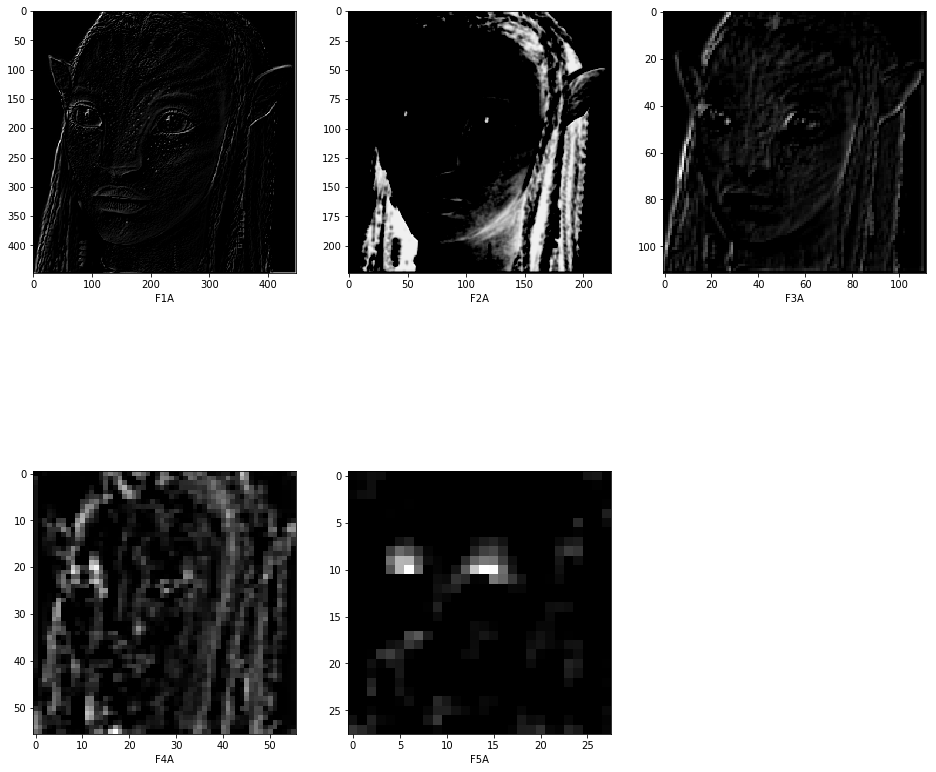

In [8]:
fig = plt.figure(figsize=(16, 24))

plt.subplot(3, 3, 1)
plt.xlabel('F1A')
plt.imshow(F1A[0][:, :, 0], cmap='gray')

plt.subplot(3, 3, 2)
plt.xlabel('F2A')
plt.imshow(F2A[0][:, :, 0], cmap='gray')

plt.subplot(3, 3, 3)
plt.xlabel('F3A')
plt.imshow(F3A[0][:, :, 0], cmap='gray')

plt.subplot(3, 3, 4)
plt.xlabel('F4A')
plt.imshow(F4A[0][:, :, 0], cmap='gray')

plt.subplot(3, 3, 5)
plt.xlabel('F5A')
plt.imshow(F5A[0][:, :, 0], cmap='gray');

In [9]:
# %load deepimageanalogy/patchmatch.py
"""Patchmatch Implementation."""

import numpy as np


class Patchmatcher(object):
    """compute an NNF that maps patches in A/A' to B/B' or vice versa."""

    def __init__(self, A, Ap, B, Bp, patchsize=3, w=None, alpha=0.5, NNF=None):
        """Instantiate a PatchMatcher object.

        Parameters
        ----------
        A: ndarray
            The original structural image.
        Ap: ndarray
            The analogous, synthetic structural image.
        B: ndarray
            The analogous, synthetic style image.
        Bp: ndarray
            The original style image.
        NNF: ndarray or None
            An array containing the offsets. Either the upsampled NNF from the
            previous layer should be passed in or None. If None, an array with
            random offsets will be created.
        """
        self.A = A
        self.Ap = Ap
        self.B = B
        self.Bp = Bp
        self.patchsize = patchsize
        # Floor division gives the before and after pad widths
        self.padwidth = self.patchsize // 2
        self.w = w or self.padwidth
        self.alpha = alpha
        self.NNF = NNF or self._random_init()

    def _random_init(self):
        """Initialize an NNF filled with random offsets."""
        # for now assume the first two input dims will always be square.
        length = self.A.shape[0] - self.padwidth*2

        NNF = np.empty((length, length, 2), dtype='int')
        for i, ix in enumerate(np.ix_(np.arange(length), np.arange(length))):
            NNF[..., i] = ix

        offsets = np.random.randint(length, size=(length, length, 2), dtype='int')

        NNF = offsets - NNF
        pad_widths = ((self.padwidth, self.padwidth), (self.padwidth, self.padwidth), (0, 0))
        NNF = np.pad(NNF, pad_widths, 'constant', constant_values=0)

        return NNF

    def _propagate(self):
        """Propagate adjacent good offsets."""
            # get the offsets f(x-1, y), and f(x, y-1)
            # compute distance D between:
            # A[x, y], B[f(x, y)], B[f(x-1, y) + (1, 0)], and B[f(x, y-1) + (0, 1)]
            # set f[x, y] to be argmin of computed distances
        # for even iterations iterate in reverse scan order and examine patches


    def _random_search(self):
        """Search for good offsets at exponentially descreasing distances."""
        # u = v0 + w * a**i * R
        i = 0
        # v0: current nearest neighbor f(x,y)
        # w: search radius. default max image dim.
        # alpha: scaling factor. default 1/2
        # i: 0, 1, 2, ... until w*a**i < 1
        # R: uniform random number in [-1, 1], [-1, 1]

    def predict(self):
        """Return an nnf."""
        # repeat 5 times
        # on odd iterations:
            # iterate over all coords x,y in NNF from (left to right, top to bottom)
            # propagate down and right
            # random search
        # on odd iterations:
            # iterate over all coords x,y in NNF from (right to left, bottom to top)
            # propagate down and right
            # random search


In [10]:
F5A[0].shape

(28, 28, 512)

In [11]:
F5B[0].shape

(28, 28, 512)

In [12]:
pm = Patchmatcher(F5A[0], F5A[0], F5B[0], F5B[0])

In [13]:
nnf = pm.NNF

In [14]:
nnf.shape

(28, 28, 2)

In [19]:
nnf[1,1]

array([25, 24])

In [20]:
scanner = np.nditer(nnf, flags=['multi_index', 'ranged'], op_flags=['readwrite'])

In [21]:
while not scanner.finished:
    print('%s: %d' % (scanner.multi_index, scanner[0]))
    scanner.iternext()

(0, 0, 0): 0
(0, 0, 1): 0
(0, 1, 0): 0
(0, 1, 1): 0
(0, 2, 0): 0
(0, 2, 1): 0
(0, 3, 0): 0
(0, 3, 1): 0
(0, 4, 0): 0
(0, 4, 1): 0
(0, 5, 0): 0
(0, 5, 1): 0
(0, 6, 0): 0
(0, 6, 1): 0
(0, 7, 0): 0
(0, 7, 1): 0
(0, 8, 0): 0
(0, 8, 1): 0
(0, 9, 0): 0
(0, 9, 1): 0
(0, 10, 0): 0
(0, 10, 1): 0
(0, 11, 0): 0
(0, 11, 1): 0
(0, 12, 0): 0
(0, 12, 1): 0
(0, 13, 0): 0
(0, 13, 1): 0
(0, 14, 0): 0
(0, 14, 1): 0
(0, 15, 0): 0
(0, 15, 1): 0
(0, 16, 0): 0
(0, 16, 1): 0
(0, 17, 0): 0
(0, 17, 1): 0
(0, 18, 0): 0
(0, 18, 1): 0
(0, 19, 0): 0
(0, 19, 1): 0
(0, 20, 0): 0
(0, 20, 1): 0
(0, 21, 0): 0
(0, 21, 1): 0
(0, 22, 0): 0
(0, 22, 1): 0
(0, 23, 0): 0
(0, 23, 1): 0
(0, 24, 0): 0
(0, 24, 1): 0
(0, 25, 0): 0
(0, 25, 1): 0
(0, 26, 0): 0
(0, 26, 1): 0
(0, 27, 0): 0
(0, 27, 1): 0
(1, 0, 0): 0
(1, 0, 1): 0
(1, 1, 0): 25
(1, 1, 1): 24
(1, 2, 0): 24
(1, 2, 1): 13
(1, 3, 0): 24
(1, 3, 1): 10
(1, 4, 0): 8
(1, 4, 1): 22
(1, 5, 0): 15
(1, 5, 1): 15
(1, 6, 0): 0
(1, 6, 1): -3
(1, 7, 0): 20
(1, 7, 1): 11
(1, 8, 0): 14
(1

In [52]:
l = 4

nnf = np.random.randint(l, size=(l**2), dtype='int')
nnf.reshape(4,4)

array([[2, 0, 3, 1],
       [3, 2, 2, 0],
       [3, 2, 2, 2],
       [0, 3, 2, 0]])

In [57]:
2 % 4

2

In [56]:
for i, o in enumerate(nnf):
    p = i // l, i % l
    bp = o // l, o % l
    lr = (nnf[i-1]+1) // l, (nnf[i-1]+1) % l
    ud = (nnf[i-l]+l) // l, (nnf[i-l]+l) % l
    print(i, o)
    print(p)
    print(bp)
    print(lr)
    print(ud)
    print('\n')

0 2
(0, 0)
(0, 2)
(0, 1)
(1, 0)


1 0
(0, 1)
(0, 0)
(0, 3)
(1, 3)


2 3
(0, 2)
(0, 3)
(0, 1)
(1, 2)


3 1
(0, 3)
(0, 1)
(1, 0)
(1, 0)


4 3
(1, 0)
(0, 3)
(0, 2)
(1, 2)


5 2
(1, 1)
(0, 2)
(1, 0)
(1, 0)


6 2
(1, 2)
(0, 2)
(0, 3)
(1, 3)


7 0
(1, 3)
(0, 0)
(0, 3)
(1, 1)


8 3
(2, 0)
(0, 3)
(0, 1)
(1, 3)


9 2
(2, 1)
(0, 2)
(1, 0)
(1, 2)


10 2
(2, 2)
(0, 2)
(0, 3)
(1, 2)


11 2
(2, 3)
(0, 2)
(0, 3)
(1, 0)


12 0
(3, 0)
(0, 0)
(0, 3)
(1, 3)


13 3
(3, 1)
(0, 3)
(0, 1)
(1, 2)


14 2
(3, 2)
(0, 2)
(1, 0)
(1, 2)


15 0
(3, 3)
(0, 0)
(0, 3)
(1, 2)




In [54]:
l = 4

o = [random.randint(0, 15) for i in range(16)]
oi = enumerate(o)

In [282]: print('patch center A: %s\noriginal B: %s\nshift a left + b right: %s\nshift a up + b down: %s' % (
     ...: (   q[0]               // l,     q[0]           % l),
     ...: (   q[1]               // l,     q[1]           % l),
     ...: ((o[q[0]-1]+1)         // l,  (o[q[0]-1]+1)     % l),
     ...: ((o[q[0]-l]+l)         // l,  (o[q[0]-l]+l)     % l)))
patch center A: (2, 1)
original B: (2, 3)
shift a left + b right: (1, 2)
shift a up + b down: (3, 3)


SyntaxError: invalid syntax (<ipython-input-54-dd6218a139c9>, line 7)

In [29]:
nnf5 = np.random.randint(4, size=(4,4))

In [30]:
nnf5

array([[2, 3, 2, 1],
       [0, 2, 1, 3],
       [3, 1, 2, 3],
       [3, 2, 2, 0]])